In [199]:
import os
from os.path import join
import re
import collections
from pathlib import Path
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import torch
from sklearn.metrics import r2_score

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Load assemblies

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
complete_genomes_df = assembly_df[assembly_df['assembly_level'] == 'Complete Genome'].copy()
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Collect protein lengths

In [4]:
def collect_protein_lengths(df):
    """
    Returns a dictionary with an entry for each assembly id. 
    This entry is itself a dictionary mapping protein id to protein length.
    """
    output = {
        assembly_id: {}
        for assembly_id in df.index
    }
    for i, assembly_id in enumerate(df.index):
        if i == 0 or (i+1) % 100 == 0:
            print(f'Assembly {i+1} / {len(df)}')
            
        assembly_output = {}
        fasta_path = os.path.join(cwd, f'data/sequences/{assembly_id}/{assembly_id}_protein.faa.gz')
        with gzip.open(fasta_path, 'rt') as f:
            for seq in SeqIO.parse(f, 'fasta'):
                assembly_output[seq.id] = len(seq)
        
        output[assembly_id] = assembly_output
        
    return output

In [5]:
protein_lengths = collect_protein_lengths(complete_genomes_df)

Assembly 1 / 2592
Assembly 100 / 2592
Assembly 200 / 2592
Assembly 300 / 2592
Assembly 400 / 2592
Assembly 500 / 2592
Assembly 600 / 2592
Assembly 700 / 2592
Assembly 800 / 2592
Assembly 900 / 2592
Assembly 1000 / 2592
Assembly 1100 / 2592
Assembly 1200 / 2592
Assembly 1300 / 2592
Assembly 1400 / 2592
Assembly 1500 / 2592
Assembly 1600 / 2592
Assembly 1700 / 2592
Assembly 1800 / 2592
Assembly 1900 / 2592
Assembly 2000 / 2592
Assembly 2100 / 2592
Assembly 2200 / 2592
Assembly 2300 / 2592
Assembly 2400 / 2592
Assembly 2500 / 2592


## Plot protein distance to mean versus protein length

In [332]:
def plot_protein_distance_to_mean_versus_protein_length_per_specie(
    df, 
    protein_lengths, 
    assembly_id, 
    log_log=False,
    ax=None,
):
    organism_name = df.loc[assembly_id]['organism_name']
    
    assembly_lengths = protein_lengths[assembly_id]

    distances_path = os.path.join(
        cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean.csv'
    )
    distances_df = pd.read_csv(distances_path, index_col='protein_id')

    union_ix = sorted(set(distances_df.index.tolist()) & set(assembly_lengths.keys()))

    all_distances = distances_df.loc[union_ix]['distance'].values.tolist()
    all_lengths = [assembly_lengths[protein_id] for protein_id in union_ix]
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    type_str = 'Log-Log' if log_log else 'Linear'
    ax.set_title(f'{organism_name} | {type_str}')
    
    
    if log_log:
        ax.scatter(np.log(all_lengths), np.log(all_distances), alpha=0.5)
        xlabel = 'Protein length (log)'
        ylabel = 'J-S distance to proteome mean (log)'
    else:
        ax.scatter(all_lengths, all_distances, alpha=0.5)
        xlabel = 'Protein length'
        ylabel = 'J-S distance to proteome mean'
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return ax

In [333]:
assembly_id = complete_genomes_df.index[10]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

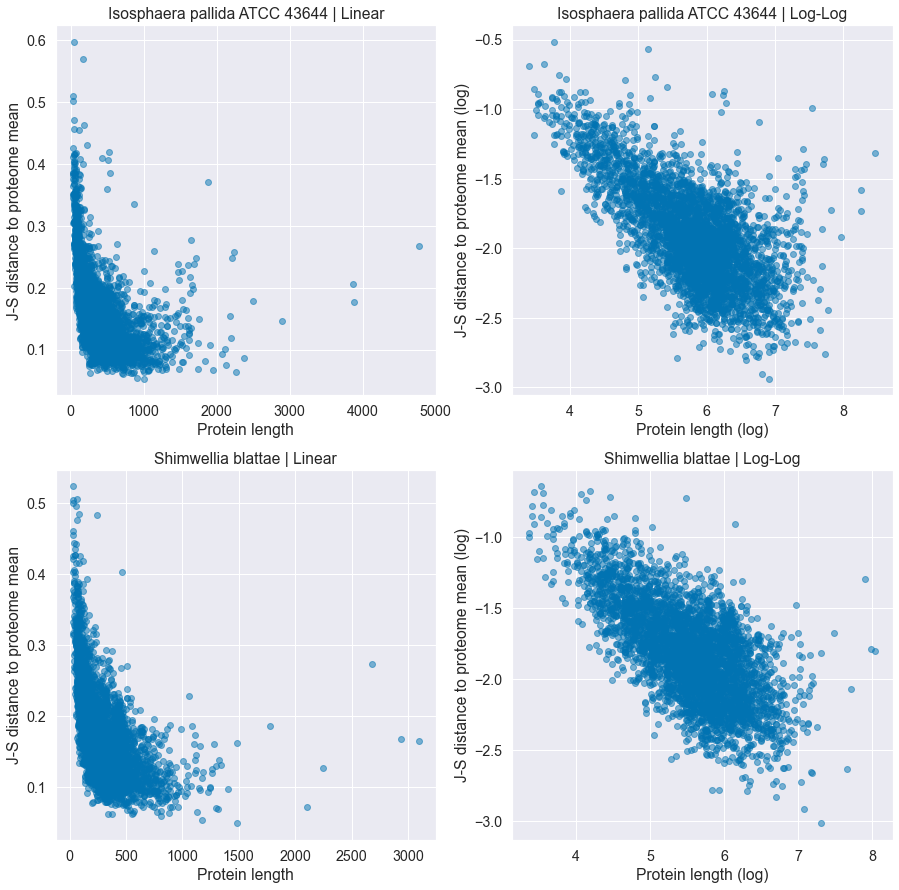

In [342]:
assembly_id_1 = complete_genomes_df.index[10]
assembly_id_2 = complete_genomes_df.index[100]

f, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

ax1 = axes[0]
plot_protein_distance_to_mean_versus_protein_length_per_specie(
    complete_genomes_df, 
    protein_lengths, 
    assembly_id_1,
    log_log=False,
    ax=ax1,
);

ax2 = axes[1]
plot_protein_distance_to_mean_versus_protein_length_per_specie(
    complete_genomes_df, 
    protein_lengths, 
    assembly_id_1,
    log_log=True,
    ax=ax2,
);

ax3 = axes[2]
plot_protein_distance_to_mean_versus_protein_length_per_specie(
    complete_genomes_df, 
    protein_lengths, 
    assembly_id_2,
    log_log=False,
    ax=ax3,
);

ax4 = axes[3]
plot_protein_distance_to_mean_versus_protein_length_per_specie(
    complete_genomes_df, 
    protein_lengths, 
    assembly_id_2,
    log_log=True,
    ax=ax4,
);
f.savefig(os.path.join(cwd, 'report/figures/length_vs_distance.eps'), bbox_inches='tight');

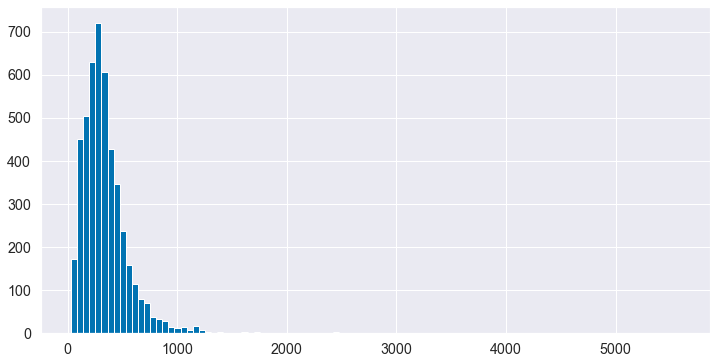

In [64]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
vals = list(protein_lengths[assembly_id].values())
ax.hist(vals, bins=100);

In [65]:
def plot_protein_distance_to_mean_versus_protein_length(df, protein_lengths, n_per_species=50, log_log=True):
    all_distances = []
    all_lengths = []
    for i, assembly_id in enumerate(df.index):
        if i == 0 or (i+1) % 100 == 0:
            print(f'Assembly {i+1} / {len(df)}')
        
        assembly_lengths = protein_lengths[assembly_id]
        
        distances_path = os.path.join(
            cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean.csv'
        )
        distances_df = pd.read_csv(distances_path, index_col='protein_id')
        
        union_ix_all = sorted(set(distances_df.index.tolist()) & set(assembly_lengths.keys()))
        
        union_ix = np.random.choice(union_ix_all, size=n_per_species, replace=False)
        
        all_distances += distances_df.loc[union_ix]['distance'].values.tolist()
        all_lengths += [assembly_lengths[protein_id] for protein_id in union_ix]
    
    assert len(all_lengths) == len(all_distances)
    
    print(len(all_lengths))
        
    _, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.scatter(all_lengths, all_distances, alpha=0.1, label='Protein')
    
    if log_log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_xlim(-100, 3000)
    
    return ax

Assembly 1 / 2592
Assembly 100 / 2592
Assembly 200 / 2592
Assembly 300 / 2592
Assembly 400 / 2592
Assembly 500 / 2592
Assembly 600 / 2592
Assembly 700 / 2592
Assembly 800 / 2592
Assembly 900 / 2592
Assembly 1000 / 2592
Assembly 1100 / 2592
Assembly 1200 / 2592
Assembly 1300 / 2592
Assembly 1400 / 2592
Assembly 1500 / 2592
Assembly 1600 / 2592
Assembly 1700 / 2592
Assembly 1800 / 2592
Assembly 1900 / 2592
Assembly 2000 / 2592
Assembly 2100 / 2592
Assembly 2200 / 2592
Assembly 2300 / 2592
Assembly 2400 / 2592
Assembly 2500 / 2592
129600


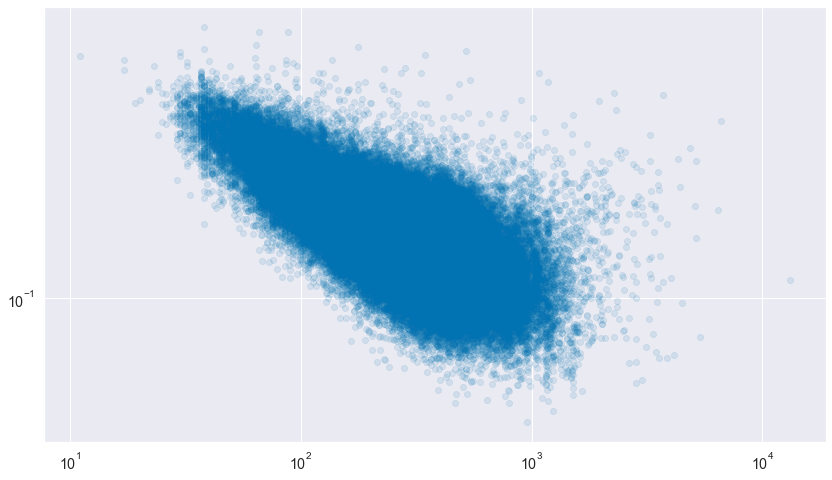

In [66]:
plot_protein_distance_to_mean_versus_protein_length(complete_genomes_df, protein_lengths);

## Fit linear model

$D_p \sim \mathcal{N}(\alpha L_p + \beta, \sigma)$

Where
- $D_p$ is the Jensen-Shannon distance of protein $p$ to the proteome.
- $L_p$ is the length of protein $p$.
- $\mathcal{N}$ is the normal distribution
- $\alpha$, $\beta$ & $\sigma$ are parameter we wish to fit.

In [81]:
class LinearNormal(torch.nn.Module):
    def __init__(self):
        """
        Define trainable paramters.
        """
        super().__init__()
        self.α = torch.nn.Parameter(torch.randn(()))
        self.β = torch.nn.Parameter(torch.randn(()))
        self.s = torch.nn.Parameter(torch.randn(()))
        
    def forward(self, x):
        m = self.α * x + self.β
        σ = torch.log(1 + torch.exp(self.s))  # softplus to ensure σ > 0 
        return torch.distributions.Normal(m, σ)

In [82]:
def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

def compute_loss(model, x, y):
    out_dist = model(x)
    return torch.mean(-out_dist.log_prob(y))

def compute_rmse(model, x_test, y_test):
    model.eval()
    out_dist = model(x_test)
    pred = out_dist.mean
    return torch.sqrt(torch.mean((pred - y_test)**2))

def predict(model, x):
    model.eval()
    out_dist = model(x)
    return out_dist.mean, out_dist.stddev

In [83]:
def train(model, optimizer, x_train, x_val, y_train, y_val, n_steps, batch_size=64, batch_seed=None, print_every=1):
    rs = np.random.RandomState(batch_seed)
    train_ix = np.arange(len(x_train))
    train_losses = []
    val_losses = []
    for step in range(n_steps):
        batch_ix = rs.choice(train_ix, size=batch_size, replace=False)
        train_loss = train_one_step(model, optimizer, x_train[batch_ix], y_train[batch_ix])
        
        model.eval()
        val_loss = compute_loss(model, x_val, y_val)
        val_rmse = compute_rmse(model, x_val, y_val)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if step == 0 or (step+1) % print_every == 0:
            print(f'Step {step+1} | Validation loss = {val_loss:.4f} | Validation RMSE = {val_rmse:.4f}')
        
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(range(1, n_steps + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_steps + 1), val_losses, label='Validation loss')
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, val_losses

In [84]:
def make_dataset(df, protein_lengths, assembly_id):
    organism_name = df.loc[assembly_id]['organism_name']
    
    assembly_lengths = protein_lengths[assembly_id]

    distances_path = os.path.join(
        cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean.csv'
    )
    distances_df = pd.read_csv(distances_path, index_col='protein_id')

    union_ix = sorted(set(distances_df.index.tolist()) & set(assembly_lengths.keys()))

    x = np.log([assembly_lengths[protein_id] for protein_id in union_ix])
    y = np.log(distances_df.loc[union_ix]['distance'].values.tolist())
    
    return torch.from_numpy(x[:,np.newaxis]), torch.from_numpy(y[:,np.newaxis])


def split_train_test(x, y, test_ratio=0.2, seed=444):
    rs = np.random.RandomState(seed)
    
    ix = np.arange(len(x))
    test_size = int(np.ceil(test_ratio * len(ix)))
    test_ix = np.random.choice(ix, size=test_size, replace=False)
    test_ix_set = set(test_ix)
    
    train_ix = np.array([i for i in ix if i not in test_ix])
    
    return train_ix, test_ix

In [85]:
model = LinearNormal()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [86]:
x, y = make_dataset(complete_genomes_df, protein_lengths, assembly_id)

In [87]:
train_ix, test_ix = split_train_test(x, y)

x_train = x[train_ix]
y_train = y[train_ix]

x_test = x[test_ix]
y_test = y[test_ix]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([2977, 1]),
 torch.Size([2977, 1]),
 torch.Size([745, 1]),
 torch.Size([745, 1]))

Step 1 | Validation loss = 1.1023 | Validation RMSE = 0.4724
Step 100 | Validation loss = 0.4367 | Validation RMSE = 0.2706
Step 200 | Validation loss = 0.0865 | Validation RMSE = 0.2589
Step 300 | Validation loss = 0.0928 | Validation RMSE = 0.2653
Step 400 | Validation loss = 0.0585 | Validation RMSE = 0.2558
Step 500 | Validation loss = 0.0694 | Validation RMSE = 0.2582
Step 600 | Validation loss = 0.0617 | Validation RMSE = 0.2551
Step 700 | Validation loss = 0.1509 | Validation RMSE = 0.2802
Step 800 | Validation loss = 0.0690 | Validation RMSE = 0.2578
Step 900 | Validation loss = 0.0598 | Validation RMSE = 0.2559
Step 1000 | Validation loss = 0.0751 | Validation RMSE = 0.2601


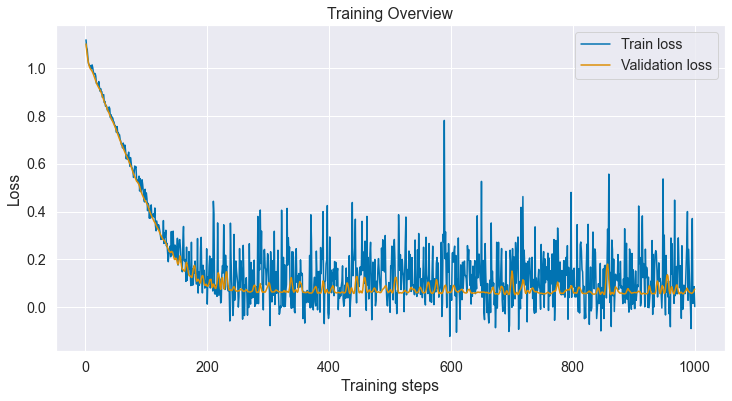

In [88]:
train_losses, val_losses = train(
    model, 
    optimizer, 
    x_train, 
    x_test, 
    y_train, 
    y_test, 
    n_steps=1000, 
    batch_size=64, 
    batch_seed=444,
    print_every=100,
)

In [89]:
x_val = torch.from_numpy(
    np.linspace(np.amin(x_test.numpy().flatten()), np.amax(x_test.numpy().flatten()))[:, np.newaxis]
)
mean, std = predict(model, x_val)
mean.shape

torch.Size([50, 1])

In [90]:
# See function to generate this output in notebook "Protein domain results (amino acid distribution)"
trna_synt_tigr_ids = {
    'Ala': ['TIGR00344'],
    'Arg': ['TIGR00456'],
    'Asn': ['TIGR00457'],
    'Asp': ['TIGR00459'],
    'Cys': ['TIGR00435'],
    'Gln': ['TIGR00440'],
    'Glu': ['TIGR00464', 'TIGR00463'],
    'Gly': ['TIGR00389', 'TIGR00211', 'TIGR00388'],
    'His': ['TIGR00442'],
    'Ile': ['TIGR00392'],
    'Leu': ['TIGR00396', 'TIGR00395'],
    'Lys': ['TIGR00499', 'TIGR00467'],
    'Met': ['TIGR00398', 'TIGR00399'],
    'Phe': ['TIGR00468', 'TIGR00472', 'TIGR00471', 'TIGR00469'],
    'Pro': ['TIGR00409', 'TIGR00408'],
    'Ser': ['TIGR00414', 'TIGR00415'],
    'Thr': ['TIGR00418'],
    'Trp': ['TIGR00233'],
    'Tyr': ['TIGR00234'],
    'Val': ['TIGR00422'],
}
trna_synt_tigr_ids_flat = []
for _, tigr_ids in trna_synt_tigr_ids.items():
    trna_synt_tigr_ids_flat += tigr_ids
    
tigr_to_protein_id_path = os.path.join(cwd, f'data/sequences/{assembly_id}/{assembly_id}_tigr.csv.gz')
tigr_df = pd.read_csv(tigr_to_protein_id_path, index_col='query')

distances_path = os.path.join(
    cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean.csv'
)
distances_df = pd.read_csv(distances_path, index_col='protein_id')

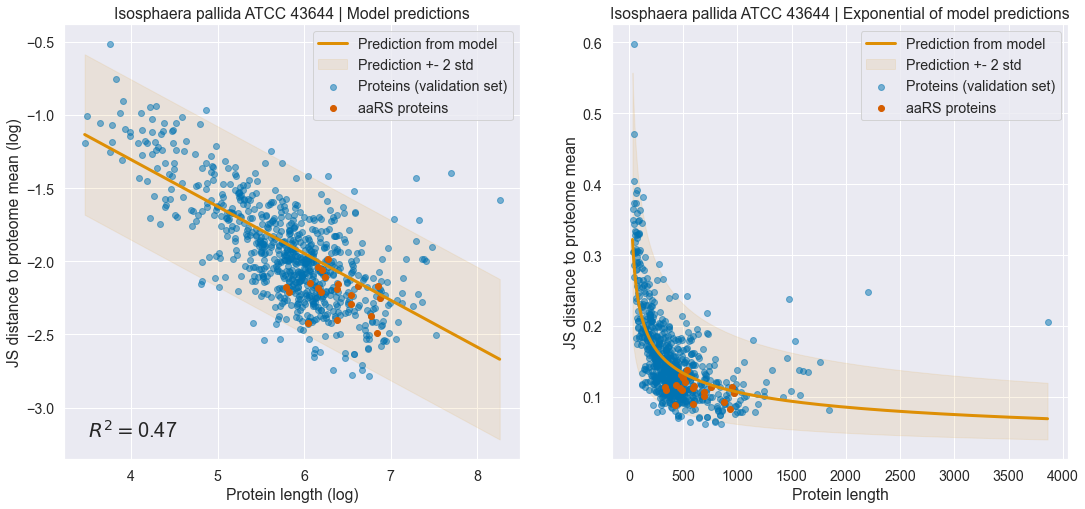

In [233]:
_, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

assembly_lengths = protein_lengths[assembly_id]
organism_name = complete_genomes_df.loc[assembly_id]['organism_name']

x_val_numpy = x_val.detach().numpy().flatten()
prediction_numpy = mean.detach().numpy().flatten()
std_numpy = std.detach().numpy().flatten()

prediction_plus_std = prediction_numpy + 2 * std_numpy
prediction_minus_std = prediction_numpy - 2 * std_numpy

trna_synt_tigr_ids_in_assembly = sorted(set(trna_synt_tigr_ids_flat) & set(tigr_df.index))

trna_synt_lengths = [
    assembly_lengths[protein_id]
    for protein_id in tigr_df.loc[trna_synt_tigr_ids_in_assembly]['protein_id'].values
    if assembly_lengths.get(protein_id)
]
trna_synt_distances = [
    distances_df.loc[[protein_id]]['distance'].iloc[0]
    for protein_id in tigr_df.loc[trna_synt_tigr_ids_in_assembly]['protein_id'].values
    if protein_id in distances_df.index
]
assert len(trna_synt_lengths) == len(trna_synt_distances)

x_pred, _ = predict(model, x_test)
r2 = r2_score(y_test.detach().numpy().flatten(), x_pred.detach().numpy().flatten())

ax = axes[0]
ax.plot(x_val_numpy, prediction_numpy, color=palette[1], linewidth=3, label='Prediction from model');
ax.fill_between(
    x_val_numpy, 
    prediction_numpy, 
    prediction_plus_std, 
    color=palette[1], 
    alpha=0.1, 
    label='Prediction +- 2 std',
);
ax.fill_between(
    x_val_numpy, 
    prediction_numpy, 
    prediction_minus_std, 
    color=palette[1], 
    alpha=0.1,
);
ax.scatter(
    x_test.numpy().flatten(), 
    y_test.numpy().flatten(), 
    alpha=0.5, 
    label='Proteins (validation set)'
);
ax.scatter(
    np.log(trna_synt_lengths),
    np.log(trna_synt_distances),
    color=palette[3],
    label='aaRS proteins',
);
ax.text(3.5, -3.2, f'$R^2 = ${r2:.2f}', fontsize=20)
ax.legend();
ax.set_ylabel('JS distance to proteome mean (log)');
ax.set_xlabel('Protein length (log)');
ax.set_title(f'{organism_name} | Model predictions');

ax2 = axes[1]
ax2.plot(
    np.exp(x_val_numpy), 
    np.exp(prediction_numpy), 
    color=palette[1], 
    linewidth=3, 
    label='Prediction from model',
);
ax2.fill_between(
    np.exp(x_val_numpy), 
    np.exp(prediction_numpy), 
    np.exp(prediction_plus_std), 
    color=palette[1], 
    alpha=0.1, 
    label='Prediction +- 2 std',
);
ax2.fill_between(
    np.exp(x_val_numpy), 
    np.exp(prediction_numpy), 
    np.exp(prediction_minus_std), 
    color=palette[1], 
    alpha=0.1,
);
ax2.scatter(
    np.exp(x_test.numpy().flatten()), 
    np.exp(y_test.numpy().flatten()), 
    color=palette[0], 
    alpha=0.5, 
    label='Proteins (validation set)',
);
ax2.scatter(
    trna_synt_lengths,
    trna_synt_distances,
    color=palette[3],
    label='aaRS proteins',
);
ax2.legend();
ax2.set_ylabel('JS distance to proteome mean');
ax2.set_xlabel('Protein length');
ax2.set_title(f'{organism_name} | Exponential of model predictions');

In [234]:
def get_protein_groups(n=50):
    path = join(os.getcwd(), 'data/tigr_aa_probability_left.csv')
    tigr_results = pd.read_csv(path, index_col='id')

    top_tigr_ids = set(tigr_results.index[:n])
    bottom_tigr_ids = set(tigr_results.index[-n:])

    return top_tigr_ids, bottom_tigr_ids

In [235]:
top_tigr_ids, bottom_tigr_ids = get_protein_groups(n=50)

In [239]:
tigr_data_path = os.path.join(
    cwd, f'data/sequences/{assembly_id}/{assembly_id}_tigr.csv.gz'
)
tigr_data = pd.read_csv(tigr_data_path, index_col='query')

In [247]:
def load_dataset(assembly_lengths, distances_df, tigr_data, tigr_ids):
    ids = set(tigr_data.index) & set(tigr_ids)
    if len(ids) == 0:
        return [], []

    relevant_protein_ids = tigr_data.loc[ids]['protein_id'].unique()
    union_ix = sorted(
        set(relevant_protein_ids) &
        set(distances_df.index.tolist()) & 
        set(assembly_lengths.keys())
    )

    x = np.log([assembly_lengths[protein_id] for protein_id in union_ix])
    y = np.log(distances_df.loc[union_ix]['distance'].values.tolist())
    
    return x, y

In [248]:
top_50_lengths, top_50_distances = load_dataset(assembly_lengths, distances_df, tigr_data, top_tigr_ids)
bottom_50_lengths, bottom_50_distances = load_dataset(assembly_lengths, distances_df, tigr_data, bottom_tigr_ids)

rs = np.random.RandomState(444)
random_control_tigr_ids = set(rs.choice(
    tigr_data.index.tolist(),
    size=min(50, len(top_50_lengths)),
    replace=False,
))
control_lengths, control_distances = load_dataset(assembly_lengths, distances_df, tigr_data, random_control_tigr_ids)

top_50_lengths.shape, bottom_50_lengths.shape, control_lengths.shape

((80,), (47,), (146,))

In [275]:
def plot_subset(ax, subset_x=None, subset_y=None, subset_label=None, subset_color=None):
    ax.plot(x_val_numpy, prediction_numpy, color=palette[1], linewidth=3, label='Prediction from model');
    ax.fill_between(
        x_val_numpy, 
        prediction_numpy, 
        prediction_plus_std, 
        color=palette[1], 
        alpha=0.1, 
        label='Prediction +- 2 std',
    );
    ax.fill_between(
        x_val_numpy, 
        prediction_numpy, 
        prediction_minus_std, 
        color=palette[1], 
        alpha=0.1,
    );
    ax.scatter(
        x_test.numpy().flatten(), 
        y_test.numpy().flatten(), 
        color='grey' if subset_x is not None else palette[0],
        alpha=0.1 if subset_x is not None else 0.5,
        label=None if subset_x is not None else 'All results (validation set)',
    );
    if subset_x is not None:
        ax.scatter(
            subset_x,
            subset_y,
            color=subset_color,
            label=subset_label,
        );
        x_pred, _ = predict(model, torch.from_numpy(subset_x[:,np.newaxis]))
        r2 = r2_score(subset_y, x_pred.detach().numpy().flatten())
    else:
        x_pred, _ = predict(model, x_test)
        r2 = r2_score(y_test.detach().numpy().flatten(), x_pred.detach().numpy().flatten())
    
    ax.text(3.5, -3.2, f'$R^2 = ${r2:.2f}', fontsize=20)
        
    ax.legend();
    ax.set_ylabel('JS distance to proteome mean (log)');
    ax.set_xlabel('Protein length (log)');
    ax.set_title(f'{organism_name} | Model predictions');

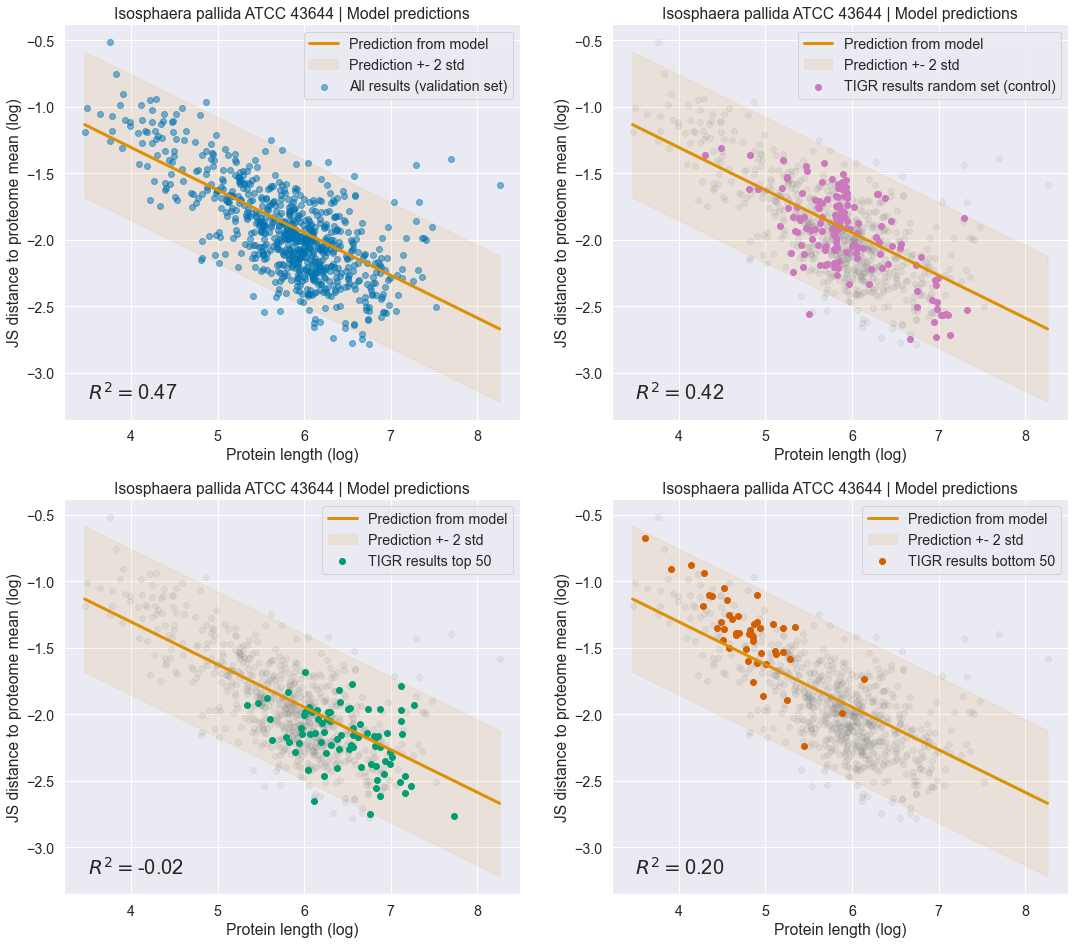

In [350]:
f, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax4 = axes[3]

plot_subset(ax1)
plot_subset(ax2, control_lengths, control_distances, 'TIGR results random set (control)', palette[4])
plot_subset(ax3, top_50_lengths, top_50_distances, 'TIGR results top 50', palette[2])
plot_subset(ax4, bottom_50_lengths, bottom_50_distances, 'TIGR results bottom 50', palette[3])
f.savefig(os.path.join(cwd, 'report/figures/length_fit_example.pdf'), bbox_inches='tight');

## Length model for each assembly: Results

In a separate script I've done the same modeling exercise for all complete genomes. 
Results are anaylised below.

In [284]:
length_model_output_path = os.path.join(cwd, 'data/confounders/length_model_output.csv')
length_model_output = pd.read_csv(length_model_output_path, index_col='assembly_accession')
length_model_output.head(10)

,overall_r2,top_50_r2,bottom_50_r2,rand_control_r2,model_slope,model_intercept,model_std
assembly_accession,,,,,,,
GCA_000010525.1,0.226133,-0.547440,0.400971,0.160044,-0.520069,1.070605,1.601319
GCA_000218545.1,0.421309,-0.227960,-0.996044,0.439312,-0.302880,-0.113405,0.563114
GCA_000020965.1,0.510238,0.112882,0.252791,0.336531,-0.381928,0.292963,0.255784
GCA_000012885.1,0.319641,-0.115424,0.510123,0.228740,-0.613122,1.577559,1.259214
GCA_000016585.1,0.480538,-0.288220,0.064488,0.336571,-0.342212,0.041765,0.243226
GCA_002222655.1,0.443402,0.076361,-0.725433,0.434027,-0.367020,0.213978,0.261050
GCA_000222485.1,0.514500,-0.309351,0.179947,-1.303818,-0.478549,0.796891,0.133096
GCA_000165715.3,0.500332,-0.307982,0.298932,0.468420,-0.468711,0.721693,1.708471
GCA_000092105.1,0.457745,0.069850,0.413908,0.549115,-0.391143,0.382877,0.258029


In [267]:
length_model_output.describe()

,overall_r2,top_50_r2,bottom_50_r2,rand_control_r2,model_slope,model_intercept,model_std
count,2589.000000,2579.000000,2577.000000,2579.000000,2589.000000,2589.000000,2589.000000
mean,0.426025,-0.443079,-0.933507,0.173642,-0.335217,0.024836,0.478412
std,0.094752,0.544929,10.744133,0.411881,0.114779,0.637765,0.357411
min,0.201787,-7.034581,-541.375860,-3.438603,-0.716511,-1.445920,0.061028
25%,0.367002,-0.619408,-1.125170,0.099159,-0.403914,-0.386928,0.255914
50%,0.431975,-0.298972,-0.323166,0.270106,-0.338718,0.047999,0.290953
75%,0.485687,-0.092310,0.109242,0.395980,-0.260899,0.405576,0.582051
max,0.773699,0.515692,0.835258,0.844538,-0.079131,1.993909,2.519519


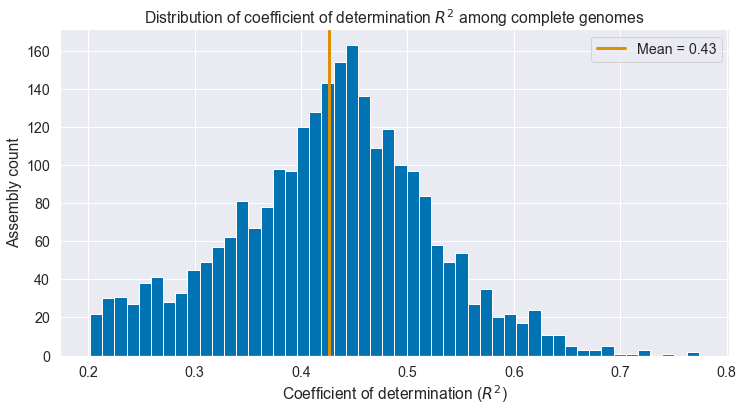

In [283]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(length_model_output['overall_r2'].values, bins=50);
mean_overall_r2 = length_model_output['overall_r2'].mean()
ax.axvline(mean_overall_r2, label=f'Mean = {mean_overall_r2:.2f}', linewidth=3, color=palette[1])
ax.set_title('Distribution of coefficient of determination $R^2$ among complete genomes');
ax.set_xlabel('Coefficient of determination ($R^2$)');
ax.set_ylabel('Assembly count');
ax.legend();

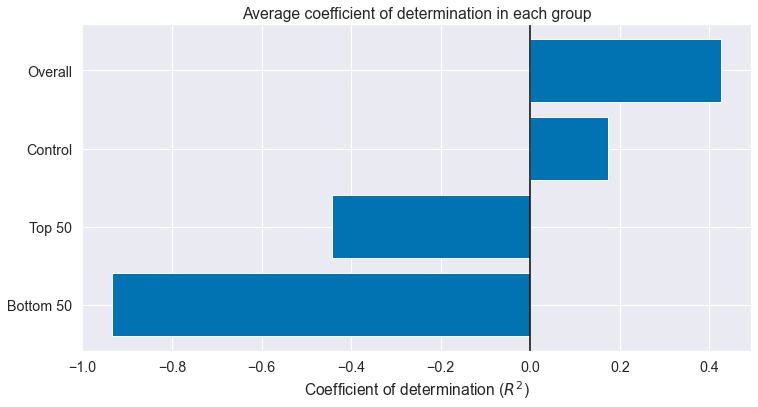

In [349]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

res = []
columns = ['overall_r2', 'rand_control_r2', 'top_50_r2', 'bottom_50_r2']
x_labels = ['Overall', 'Control', 'Top 50', 'Bottom 50']
means = [
    length_model_output[col].mean()
    for col in columns
]
ax.barh(list(reversed(x_labels)), list(reversed(means)));
ax.set_xlabel('Coefficient of determination ($R^2$)')
ax.axvline(0, color='black');
ax.set_title('Average coefficient of determination in each group');
f.savefig(os.path.join(cwd, 'report/figures/r_squared_comparison.eps'), bbox_inches='tight');

## Compute average length in each group (top, bottom, control)

In [302]:
def load_length_dataset(assembly_lengths, tigr_data, tigr_ids):
    ids = set(tigr_data.index) & set(tigr_ids)
    if len(ids) == 0:
        return [], []

    relevant_protein_ids = tigr_data.loc[ids]['protein_id'].unique()
    union_ix = sorted(
        set(relevant_protein_ids) &
        set(assembly_lengths.keys())
    )
    return [
        assembly_lengths[protein_id] for protein_id in union_ix
        if isinstance(assembly_lengths.get(protein_id), int)
    ]


def load_length_from_each_group(df, protein_lengths, n=50):
    top_tigr_ids, bottom_tigr_ids = get_protein_groups(n)
    
    data = {
        'top_50_length': [],
        'bottom_50_length': [],
        'control_length': [],
    }
    for i, assembly_id in enumerate(df.index):
        if i == 0 or (i+1) % 100 == 0:
            print(f'Assembly {i + 1} / {len(df)}')
            
        assembly_lengths = protein_lengths[assembly_id]
        
        tigr_data_path = os.path.join(
            cwd, f'data/sequences/{assembly_id}/{assembly_id}_tigr.csv.gz'
        )
        tigr_data = pd.read_csv(tigr_data_path, index_col='query')
        
        top_lengths = load_length_dataset(assembly_lengths, tigr_data, top_tigr_ids)
        bottom_lengths = load_length_dataset(assembly_lengths, tigr_data, bottom_tigr_ids)
        
        control_lengths = []
        if len(top_lengths) > 1:
            random_control_tigr_ids = set(np.random.choice(
                tigr_data.index.tolist(),
                size=min(n, len(top_lengths)),
                replace=False,
            ))
            control_lengths = load_length_dataset(assembly_lengths, tigr_data, random_control_tigr_ids)
            
        data['top_50_length'] += top_lengths
        data['bottom_50_length'] += bottom_lengths
        data['control_length'] += control_lengths
        
    return data

In [303]:
lengths_per_group = load_length_from_each_group(complete_genomes_df, protein_lengths)

Assembly 1 / 2592
Assembly 100 / 2592
Assembly 200 / 2592
Assembly 300 / 2592
Assembly 400 / 2592
Assembly 500 / 2592
Assembly 600 / 2592
Assembly 700 / 2592
Assembly 800 / 2592
Assembly 900 / 2592
Assembly 1000 / 2592
Assembly 1100 / 2592
Assembly 1200 / 2592
Assembly 1300 / 2592
Assembly 1400 / 2592
Assembly 1500 / 2592
Assembly 1600 / 2592
Assembly 1700 / 2592
Assembly 1800 / 2592
Assembly 1900 / 2592
Assembly 2000 / 2592
Assembly 2100 / 2592
Assembly 2200 / 2592
Assembly 2300 / 2592
Assembly 2400 / 2592
Assembly 2500 / 2592


In [304]:
np.mean(lengths_per_group['top_50_length'])

619.8704027830032

In [310]:
np.mean([v for v in lengths_per_group['bottom_50_length'] if isinstance(v, int)])

129.68193553013734

In [306]:
np.mean(lengths_per_group['control_length'])

462.0008564262556

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


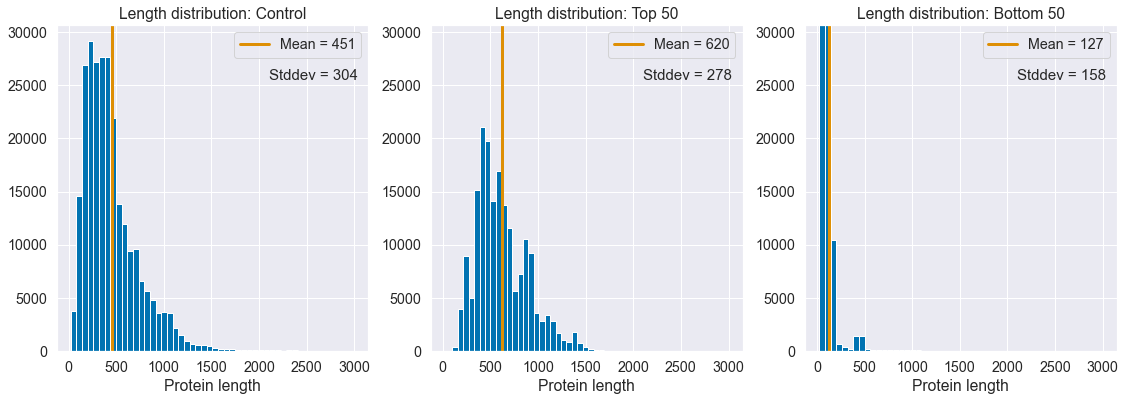

In [351]:
f, axes = plt.subplots(1, 3, figsize=(19, 6))
axes = axes.flatten()

cols = ['control_length', 'top_50_length', 'bottom_50_length']
labels = ['Control', 'Top 50', 'Bottom 50']
xlim = None
ylim = None
for i, ax in enumerate(axes):
    d = [v for v in lengths_per_group[cols[i]] if isinstance(v, int) and v < 3000]
    mean = np.mean(d)
    std = np.std(d)
    ax.hist(d, bins=50)
    ax.axvline(mean, color=palette[1], linewidth=3, label=f'Mean = {mean:.0f}')
    ax.legend()
    ax.set_title(f'Length distribution: {labels[i]}')
    ax.text(2100, 25500, f'Stddev = {std:.0f}', fontsize=15)
    ax.set_xlabel('Protein length');
    
    if i == 0:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
f.savefig(os.path.join(cwd, 'report/figures/average_protein_length.eps'), bbox_inches='tight');

## Synthetic distance based purely on length (control)

1. Assign the longest protein the shortest distance, assign the second longest protein the second shortest distance etc. 
2. After re-assigning distances based on protein length, repeat the enrichment analysis. 
3. If tRNA synthetases still come out top, we can explain this purely by their length (since amino acid composition is not explicitly considered in this control).

Here we start by creating the synthetic distance files for each complete genome (step 1)

In [361]:
def re_assign_distance_based_on_length(df, protein_lengths):
    for i, assembly_id in enumerate(df.index):
        if i == 0 or (i+1) % 100 == 0:
            print(f'Assembly {i + 1} / {len(df)}')
            
        assembly_lengths = protein_lengths[assembly_id]
        
        # Save protein lengths
        protein_length_path = os.path.join(cwd, f'data/sequences/{assembly_id}/{assembly_id}_protein_lengths.csv')
        lengths_data = {
            'protein_id': [],
            'length': [],
        }
        for protein_id in sorted(assembly_lengths.keys()):
            lengths_data['protein_id'].append(protein_id)
            lengths_data['length'].append(assembly_lengths[protein_id])
        
        protein_lengths_df = pd.DataFrame.from_dict(lengths_data).set_index('protein_id')
        protein_lengths_df.sort_values('length').to_csv(protein_length_path)
        
        # Load distances
        distances_path = os.path.join(
            cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean.csv'
        )
        if not os.path.isfile(distances_path):
            print(f'Warning: no distances file for assembly {assembly_id}')
            continue
        
        distances_df = pd.read_csv(distances_path, index_col='protein_id')
        
        if len(distances_df) == 0:
            print(f'Warning: no distances for assembly {assembly_id}')
            continue
        
        # Find union of protein ids
        union_ix = set(distances_df.index) & set(protein_lengths_df.index)
        if len(union_ix) == 0:
            print(f'Warning: no overlap between distances and lengths for assembly {assembly_id}')
            continue
        
        # Assign distance based on length
        distances_df = distances_df.loc[union_ix].sort_values('distance').copy()
        protein_lengths_df = protein_lengths_df.loc[union_ix].sort_values('length').copy()
        
        seen_protein_ids = set()
        for row_ix, protein_id in enumerate(distances_df.index):
            if protein_id in seen_protein_ids:
                continue
            
            opposite_row_ix = len(distances_df) - row_ix - 1
            if opposite_row_ix == row_ix:
                seen_protein_ids.add(protein_id)
                continue
            
            other_protein_id = protein_lengths_df.index[opposite_row_ix]
            original_distance = distances_df.loc[protein_id, 'distance']
            distances_df.loc[protein_id, 'distance'] = distances_df.loc[other_protein_id, 'distance']
            distances_df.loc[other_protein_id, 'distance'] = original_distance
            
            seen_protein_ids.add(protein_id)
            seen_protein_ids.add(other_protein_id)
            
        # Save synthetic distances
        synthetic_distances_path = os.path.join(
            cwd, f'data/sequences/{assembly_id}/{assembly_id}_amino_acid_distance_to_mean__length_control.csv'
        )
        distances_df.sort_values('distance').to_csv(synthetic_distances_path)


In [362]:
%%time
# re_assign_distance_based_on_length(complete_genomes_df, protein_lengths)

Assembly 1 / 2592
Assembly 100 / 2592
Assembly 200 / 2592
Assembly 300 / 2592
Assembly 400 / 2592
Assembly 500 / 2592
Assembly 600 / 2592
Assembly 700 / 2592
Assembly 800 / 2592
Assembly 900 / 2592
Assembly 1000 / 2592
Assembly 1100 / 2592
Assembly 1200 / 2592
Assembly 1300 / 2592
Assembly 1400 / 2592
Assembly 1500 / 2592
Assembly 1600 / 2592
Assembly 1700 / 2592
Assembly 1800 / 2592
Assembly 1900 / 2592
Assembly 2000 / 2592
Assembly 2100 / 2592
Assembly 2200 / 2592
Assembly 2300 / 2592
Assembly 2400 / 2592
Assembly 2500 / 2592
CPU times: user 22min 42s, sys: 17.1 s, total: 22min 59s
Wall time: 23min 14s
